In [1]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
img_size = 224

In [4]:
# open xlsx file using the openpyxl engine

#df_data = pd.read_excel("../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx", engine = 'openpyxl')
#df_data.head()

# open csv file (note - target and filename only references one single eye)

df_data = pd.read_csv("/content/drive/MyDrive/ODIR-5K/full_df.csv")
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [5]:
df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [8]:
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [9]:
img_dir = "/content/drive/MyDrive/ODIR-5K/ODIR images"

In [10]:
# Left diagnosis with 'cataract' keyword

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [11]:
## let's place the left cataract data into its own dataframe and print the number of rows

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [12]:
# Right diagnosis with 'cataract' keyword

df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [13]:
## let's place the right cataract data into its own dataframe and print the number of rows

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


In [14]:


df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()



<ipython-input-14-5931265ca91a>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)


0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

In [15]:
df_cat_filenames.tail()

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

In [16]:
len(df_cat_filenames)

572

(512, 512, 3)
2120_right.jpg


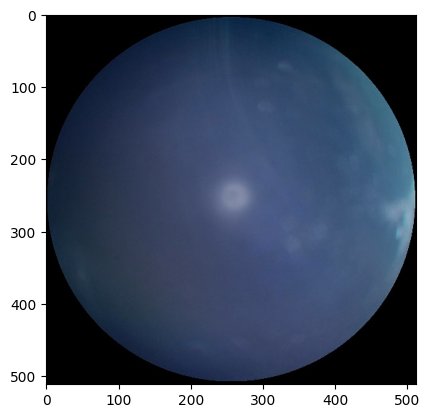

In [17]:
img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(img)

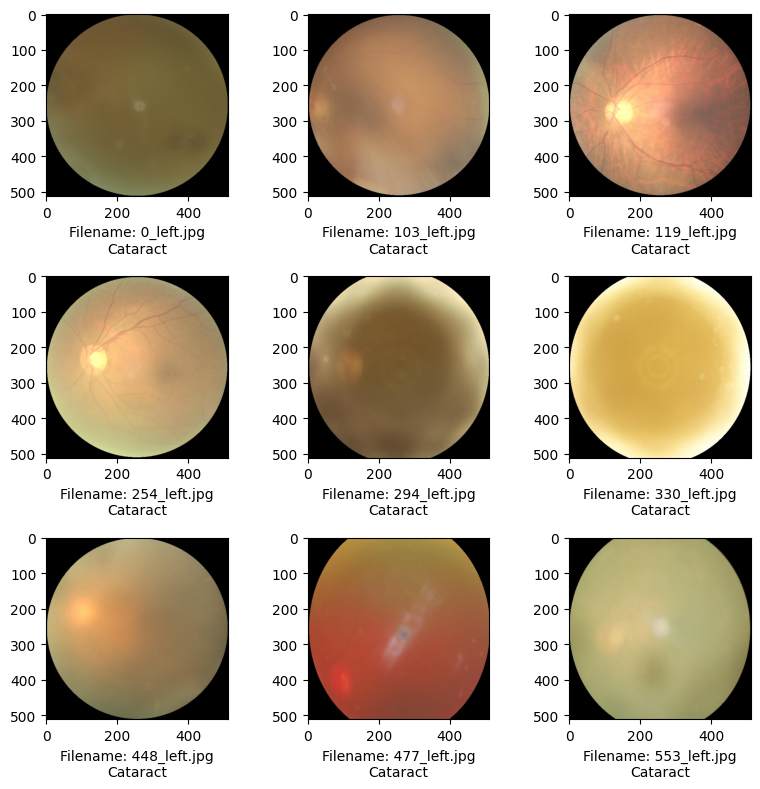

In [18]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout() 

We now need to gather a set of normal images. First let's see how many normal images there are available to us - we did this earlier but let's take a look again. Remember, we're working with two eyes and we noticed that some of the encoded columns don't have data for both eyes, so the whole story is not truly told. We need to look at the labeling in the keywords as that seems to be the source of truth when considering both eyes.

In [19]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

In [20]:
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [21]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [22]:
## let's place the Normal data into its own dataframe and print the number of rows

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


In [23]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

<ipython-input-23-949d248025f1>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)


0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

In [24]:
## remember we're choosing 572 to equal the number of cataract images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

3065    1093_right.jpg
4798    2659_right.jpg
4952    2834_right.jpg
3548    2776_right.jpg
5135    3040_right.jpg
dtype: object

In [25]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0      1093_right.jpg
1      2659_right.jpg
2      2834_right.jpg
3      2776_right.jpg
4      3040_right.jpg
            ...      
567      650_left.jpg
568    3433_right.jpg
569     3152_left.jpg
570     3139_left.jpg
571     2651_left.jpg
Length: 572, dtype: object

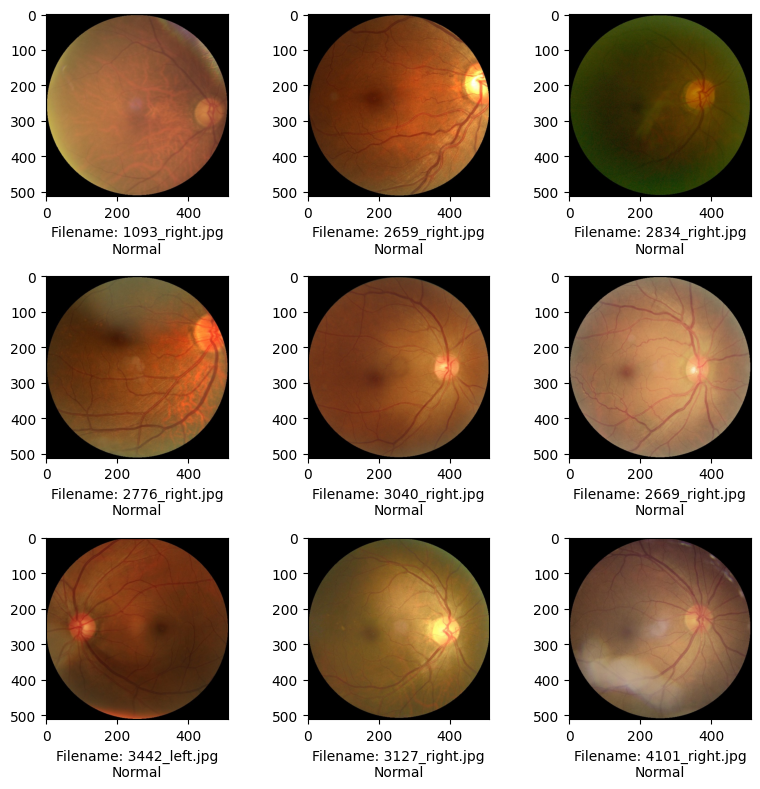

In [26]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout() 

In [27]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [28]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,1093_right.jpg,normal
1,2659_right.jpg,normal
2,2834_right.jpg,normal
3,2776_right.jpg,normal
4,3040_right.jpg,normal


In [29]:
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

<ipython-input-29-d381ac5e70cc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)


,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1139,650_left.jpg,normal
1140,3433_right.jpg,normal
1141,3152_left.jpg,normal
1142,3139_left.jpg,normal


In [30]:
df_rt_ret = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')]
print(len(df_rt_ret))

898


In [31]:
df_left_ret = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('moderate non proliferative retinopathy')]
print(len(df_left_ret))

850


In [32]:

df_cat_filenames = df_left_ret['Left-Fundus'].append(df_rt_ret['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()

<ipython-input-32-269157b09dd1>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_ret['Left-Fundus'].append(df_rt_ret['Right-Fundus'], ignore_index=True)


0     5_left.jpg
1    11_left.jpg
2    26_left.jpg
3    44_left.jpg
4    46_left.jpg
dtype: object

In [33]:
df_ret_filenames_random = df_norm_filenames.sample(n = 572)
len(df_ret_filenames_random)

572

In [34]:
df_ret_filenames_random = pd.DataFrame(df_ret_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_ret_filenames_random["label"] = "retinopathy"

df_ret_filenames_random.head()

,filename,label
4332,481_right.jpg,retinopathy
2963,548_right.jpg,retinopathy
2471,3167_left.jpg,retinopathy
1515,513_left.jpg,retinopathy
1558,737_left.jpg,retinopathy


In [35]:
df_combined = df_combined.append(df_ret_filenames_random, ignore_index=True)
df_combined

<ipython-input-35-a6031ba376d3>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df_ret_filenames_random, ignore_index=True)


,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1711,3066_right.jpg,retinopathy
1712,3027_right.jpg,retinopathy
1713,2961_right.jpg,retinopathy
1714,3409_left.jpg,retinopathy


In [36]:
df_rt_em = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('epiretinal membrane')]
print(len(df_rt_em))

138


In [37]:
df_left_em = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('epiretinal membrane')]
print(len(df_left_em))

145


In [38]:
df_cat_filenames = df_left_em['Left-Fundus'].append(df_rt_em['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()

<ipython-input-38-325d4bc181f5>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_em['Left-Fundus'].append(df_rt_em['Right-Fundus'], ignore_index=True)


0    10_left.jpg
1    21_left.jpg
2    29_left.jpg
3    31_left.jpg
4    61_left.jpg
dtype: object

In [39]:
df_ret_filenames_random = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_ret_filenames_random["label"] = "epiretinal membrane"

df_ret_filenames_random.head()

,filename,label
0,10_left.jpg,epiretinal membrane
1,21_left.jpg,epiretinal membrane
2,29_left.jpg,epiretinal membrane
3,31_left.jpg,epiretinal membrane
4,61_left.jpg,epiretinal membrane


In [40]:
df_combined = df_combined.append(df_ret_filenames_random, ignore_index=True)
df_combined

<ipython-input-40-a6031ba376d3>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_combined.append(df_ret_filenames_random, ignore_index=True)


,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1994,1462_right.jpg,epiretinal membrane
1995,1471_right.jpg,epiretinal membrane
1996,1999_right.jpg,epiretinal membrane
1997,2124_right.jpg,epiretinal membrane


In [41]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,2194_right.jpg,cataract
1,2977_right.jpg,normal
2,977_right.jpg,retinopathy
3,21_left.jpg,epiretinal membrane
4,2362_left.jpg,retinopathy
...,...,...
1994,1484_left.jpg,cataract
1995,2490_right.jpg,retinopathy
1996,51_right.jpg,epiretinal membrane
1997,501_left.jpg,epiretinal membrane


In [42]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1999
1599
400


In [43]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

In [44]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [45]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 1280 validated image filenames belonging to 4 classes.
Found 319 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.


In [46]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

In [47]:
train_labels[0]

array([0., 0., 1., 0.], dtype=float32)

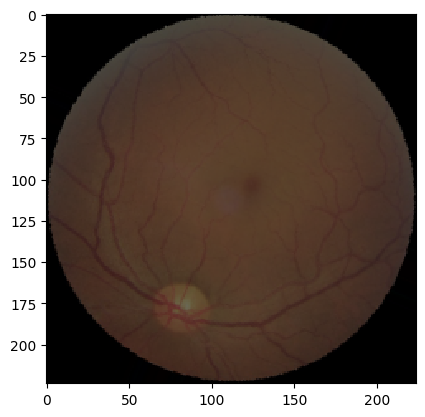

In [48]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()

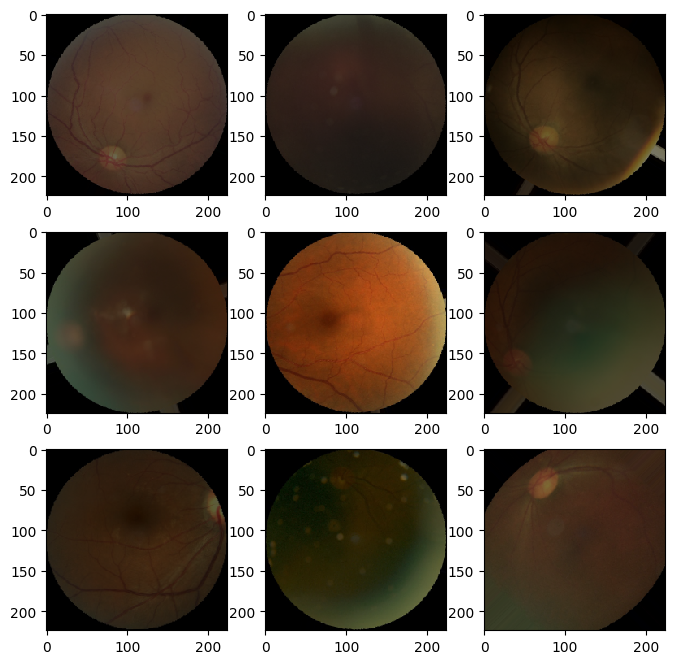

In [49]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 




Build our transfer learning model

Here we load the vgg16 model, but since we are doing transfer learning, we don't want the fully connected portion, so we will rip it off with the include_top FALSE option. We don't want this because we have a custom dataset that has a custom number of outputs, 2 in this case.

We will use the 'imagenet' weights since those filters / weights / kernels will help us find edges, corners, rounded areas of our images. Those are already baked in and we can speed this process up by using some that are proven to be effective for thousands of images.

We will drop 50% of the perceptrons during the final layer to avoid overfitting.

We will use the ADAM gradient descent optimizer as well.


In [50]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(4, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers[0:-10]:
    layer.trainable = False
    
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step



Create check point and early stop

A check point allows us to monitor the acuraccy and perform some task, in this case we will save the model as a file.

The early stop will monitor accuracy for a 'patience' parameter and if there is no improvement it will stop.


In [51]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')



From: https://stackoverflow.com/questions/46820609/how-the-keras-steps-per-epoch-in-fit-generator-works

The steps_per_epoch parameter is the number of batches of samples it will take to complete one full epoch. This is dependent on your batch size. The batch size is set where you initialize your training data. For example, if you're doing this with ImageDataGenerator.flow() or ImageDataGenerator.flow_from_directory(), the batch size is specified with the batch_size parameter in each of these.

With 3000 samples for example:

If your batch size was 100, then steps_per_epoch would be 30.
If your batch size was 10, then steps_per_epoch would be 300.
If your batch size was 1, then steps_per_epoch would be 3000.

This is because steps_per_epoch should be equivalent to the total number of samples divided by the batch size. The process of implementing this in Keras is available in the two videos below.
Constants for our training run

SPE is 'steps per epoch'

n_val_steps is 'number of validation steps'


In [52]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

40 9


In [53]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint])

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 1.4457 - accuracy: 0.2625
Epoch 1: val_accuracy improved from -inf to 0.27431, saving model to vgg16_1.h5
40/40 [==============================] - 98s 2s/step - loss: 1.4457 - accuracy: 0.2625 - val_loss: 1.3359 - val_accuracy: 0.2743
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 1.3548 - accuracy: 0.2922
Epoch 2: val_accuracy improved from 0.27431 to 0.34375, saving model to vgg16_1.h5
40/40 [==============================] - 43s 1s/step - loss: 1.3548 - accuracy: 0.2922 - val_loss: 1.3343 - val_accuracy: 0.3438
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 1.3471 - accuracy: 0.3336
Epoch 3: val_accuracy did not improve from 0.34375
40/40 [==============================] - 45s 1s/step - loss: 1.3471 - accuracy: 0.3336 - val_loss: 1.3471 - val_accuracy: 0.3333
Epoch 4/30
40/40 [==============================] - ETA: 0s - loss: 1.3577 - accuracy: 0.3125
Epoch 4: val_accuracy d

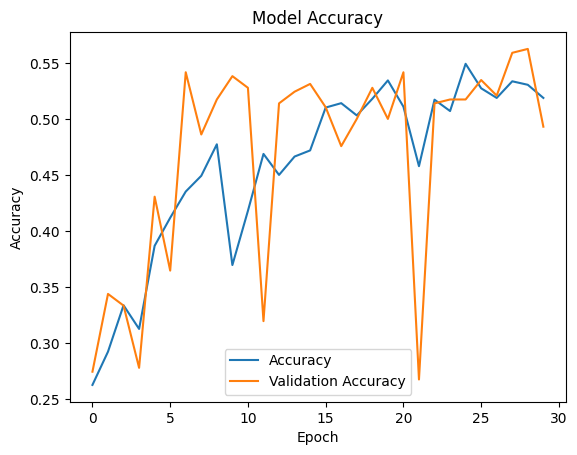

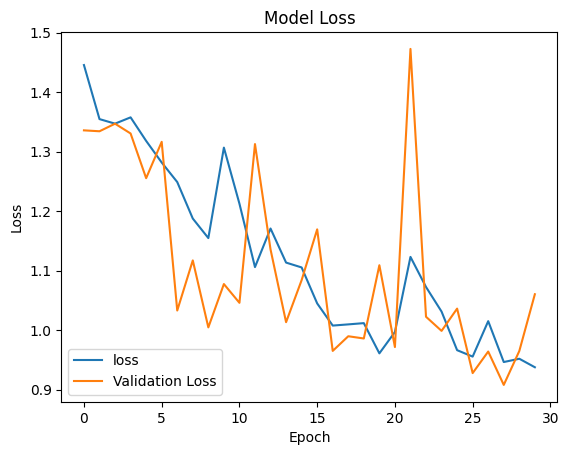

In [54]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

In [55]:
test_generator.reset()

In [56]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)

<ipython-input-56-f4d95dc2fe8f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


12/12 [==============================] - 52s 5s/step


In [57]:
print(pred[0:10])

[[2.58335955e-02 3.36157471e-01 3.52760822e-01 2.85248131e-01]
 [1.01448080e-04 9.55231786e-02 6.28304780e-01 2.76070595e-01]
 [4.28998247e-02 2.67048478e-01 3.66111696e-01 3.23940009e-01]
 [5.68352407e-03 2.06043482e-01 4.54609096e-01 3.33663851e-01]
 [7.13718295e-01 3.33290659e-02 1.32219911e-01 1.20732784e-01]
 [1.59753710e-02 2.73052007e-01 3.88929039e-01 3.22043568e-01]
 [5.89062423e-02 2.76855767e-01 3.34870398e-01 3.29367638e-01]
 [1.66448891e-01 2.58249760e-01 2.82374263e-01 2.92927057e-01]
 [3.60292196e-03 1.63997725e-01 4.84138221e-01 3.48261088e-01]
 [6.46650046e-03 2.55303949e-01 4.39813435e-01 2.98416138e-01]]


Convert Raw Prediction Data

In [58]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[2 2 2 2 0 2 2 3 2 2]


In [59]:
print(len(predicted_class_idx))

400


In [60]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

13/13 [==============================] - 6s 258ms/step - loss: 1.0984 - accuracy: 0.4950


[1.0984381437301636, 0.4950000047683716]

In [61]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('epiretinal membrane', 1), ('normal', 2), ('retinopathy', 3)])

In [62]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [63]:
pred_labels[1:10]

['normal',
 'normal',
 'normal',
 'cataract',
 'normal',
 'normal',
 'retinopathy',
 'normal',
 'normal']

In [64]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,2977_right.jpg,normal
1,4130_left.jpg,normal
2,636_left.jpg,normal
3,3394_left.jpg,normal
4,2138_right.jpg,cataract


In [65]:
prediction_df.iloc[35]

Filename      2209_right.jpg
Prediction          cataract
Name: 35, dtype: object

In [66]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2209_right.jpg
0



Correct vs. Incorrect list

Now that we have lightly verified our test and prediction data is aligned, we can list all of our predictions and compare them to our test data. This is only an example using a small test dataset (under 1000). I can't possibly recommend this for a large dataset.


In [67]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class} {pred_index}    {true_class}      {file}')

{'cataract': 0, 'epiretinal membrane': 1, 'normal': 2, 'retinopathy': 3}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   normal 2    normal      2977_right.jpg
 Correct   normal 2    normal      4130_left.jpg
 Wrong     normal 2    epiretinal membrane      636_left.jpg
 Correct   normal 2    normal      3394_left.jpg
 Correct   cataract 0    cataract      2138_right.jpg
 Wrong     normal 2    retinopathy      685_right.jpg
 Wrong     normal 2    retinopathy      3363_left.jpg
 Wrong     retinopathy 3    cataract      1490_right.jpg
 Wrong     normal 2    retinopathy      2570_left.jpg
 Wrong     normal 2    epiretinal membrane      657_right.jpg
 Wrong     normal 2    epiretinal membrane      1119_left.jpg
 Wrong     normal 2    retinopathy      527_right.jpg
 Wrong     normal 2    cataract      2149_right.jpg
 Correct   cataract 0    cataract      2104_right.jpg
 Wrong     normal 2    epiretinal membrane      405_right.jpg
 Correct   cataract 0    cataract      2211_right

In [68]:
x_test, y_test = test_generator.next()

In [69]:
print(len(x_test))
print(len(y_test))


## compare this length to our prediction data and notice the difference.  

print(len(pred))

32
32
400


In [70]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

1/1 [==============================] - 0s 211ms/step - loss: 1.2193 - accuracy: 0.4375
loss: 1.2193156480789185
Accuracy: 0.4375


In [71]:
test_image_data, test_labels = test_generator.next()

In [72]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 4)


In [73]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

2977_right.jpg
2


'normal'

In [74]:
test_labels[5]

array([0., 0., 0., 1.], dtype=float32)

In [75]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([0, 0, 0, 0, 0, 3, 2, 3, 2, 1, 0, 0, 2, 1, 0, 0, 2, 3, 2, 2, 2, 1,
       2, 0, 2, 3, 2, 3, 0, 0, 0, 0])

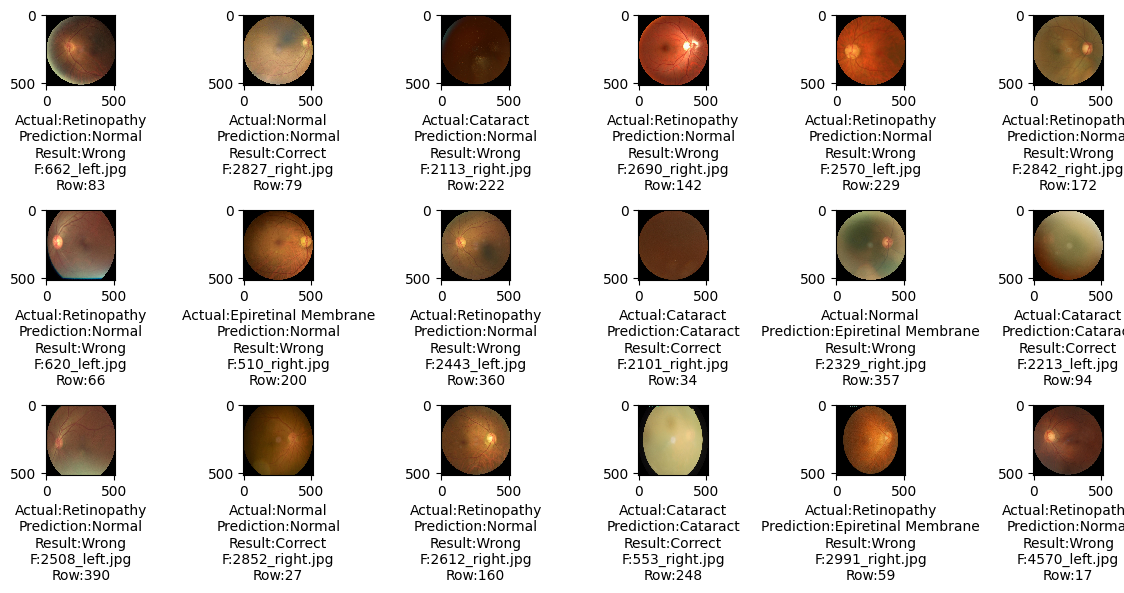

In [76]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
           
    
    if category== 0:
        label = "Cataract"
    elif category==1:
        label = "Epiretinal Membrane"
    elif category==2:
        label= "Normal"
    else:
        label="Retinopathy"
        
    if pred_category== "normal":
        pred_label = "Normal"
    elif pred_category== "cataract":
        pred_label = "Cataract"
    elif pred_category=="retinopathy":
        pred_label = "Retinopathy"
    else:
        pred_label = "Epiretinal Membrane"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout() 

In [77]:
print('Classification Report')
target_names = ['Cataract', 'Normal', 'Retinopathy', 'Epiretinal Membrane']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
                     precision    recall  f1-score   support

           Cataract       0.98      0.78      0.87       118
             Normal       0.33      0.14      0.20        57
        Retinopathy       0.35      0.93      0.51       104
Epiretinal Membrane       0.17      0.01      0.02       121

           accuracy                           0.49       400
          macro avg       0.46      0.47      0.40       400
       weighted avg       0.48      0.49      0.42       400



In [78]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[ 92,   4,  18,   4],
       [  0,   8,  48,   1],
       [  1,   6,  97,   0],
       [  1,   6, 113,   1]])

In [79]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [80]:
cm_plot_labels = ['cataract','normal']



We can see that the y-axis is the true (test) labels and the x-axis is the predicted output.

Correct items are where both the true and predicted cells meet - the categories are similar, in this case, a darker color.

Incorrect items are lighter in color and are where the true and predicted cells have disimilar categories.


Confusion matrix, without normalization
[[ 92   4  18   4]
 [  0   8  48   1]
 [  1   6  97   0]
 [  1   6 113   1]]


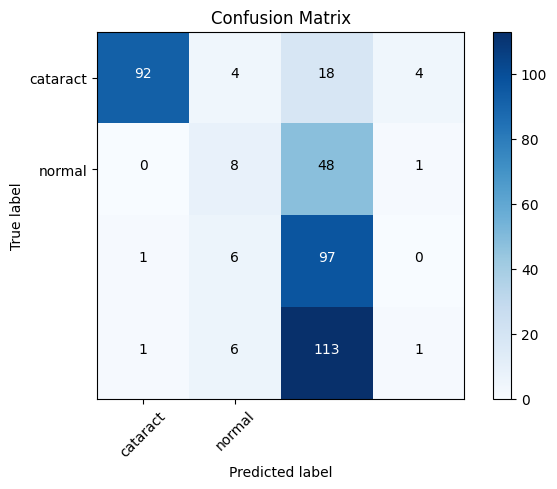

In [81]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [82]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [83]:
import gradio as gr

In [84]:
class_names=['Cataract', 'Normal', 'Retinopathy', 'Epiretinal Membrane']
def predict_image(img):
  img_4d=img.reshape(-1,224,224,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(4)}

            filename                label
0     2194_right.jpg             cataract
1     2977_right.jpg               normal
2      977_right.jpg          retinopathy
3        21_left.jpg  epiretinal membrane
4      2362_left.jpg          retinopathy
...              ...                  ...
1994   1484_left.jpg             cataract
1995  2490_right.jpg          retinopathy
1996    51_right.jpg  epiretinal membrane
1997    501_left.jpg  epiretinal membrane
1998  2375_right.jpg          retinopathy

[1999 rows x 2 columns]
2194_right.jpg
2977_right.jpg
977_right.jpg
21_left.jpg
2362_left.jpg
1166_left.jpg
3940_left.jpg
1093_right.jpg
4130_left.jpg


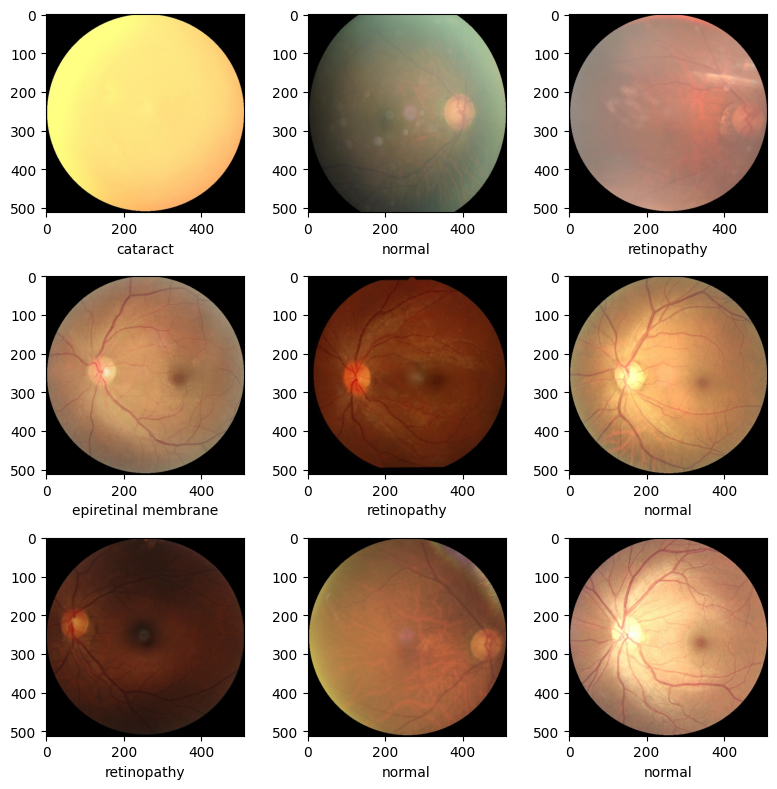

In [94]:
plt.figure(figsize=(8,8))
print(df_combined_random)
for i in range(9):
    img = df_combined_random['filename'][i]
    print(img)
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel(df_combined_random['label'][i])

plt.tight_layout() 

In [ ]:
image = gr.inputs.Image(shape=(224,224))
label = gr.outputs.Label(num_top_classes=4)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default', title="Recognition of Ocular Diseases using Deep Learning Techniques").launch(debug='True', share='True')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:200: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  super().__init__(num_top_classes=num_top_classes, type=type, label=label)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://eca8312c814c416f41.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 20ms/step
